# In the Name of Allah

Pattern Final Project

Author: Ali Asghar Taghizadeh

Student number: 98922004

Date: 1399/11/15

# Imports

In [1]:
%%capture
!pip install transformers

In [2]:
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
from torchsummary import summary


import pandas as pd
import transformers
from tqdm.notebook import tqdm
import pickle
import numpy as np
from time import time

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.utils.class_weight import compute_class_weight

# Dataset

In [3]:
!wget https://mind201910small.blob.core.windows.net/release/MINDsmall_train.zip
!wget https://mind201910small.blob.core.windows.net/release/MINDsmall_dev.zip
!unzip MINDsmall_train.zip -d train
!unzip MINDsmall_dev.zip -d dev

--2021-02-03 08:33:24--  https://mind201910small.blob.core.windows.net/release/MINDsmall_train.zip
Resolving mind201910small.blob.core.windows.net (mind201910small.blob.core.windows.net)... 20.150.34.36
Connecting to mind201910small.blob.core.windows.net (mind201910small.blob.core.windows.net)|20.150.34.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52952752 (50M) [application/octet-stream]
Saving to: ‘MINDsmall_train.zip’

MINDsmall_train.zip 100%[===================>]  50.50M  10.6MB/s    in 5.1s    

2021-02-03 08:33:29 (9.97 MB/s) - ‘MINDsmall_train.zip’ saved [52952752/52952752]

--2021-02-03 08:33:29--  https://mind201910small.blob.core.windows.net/release/MINDsmall_dev.zip
Resolving mind201910small.blob.core.windows.net (mind201910small.blob.core.windows.net)... 20.150.34.36
Connecting to mind201910small.blob.core.windows.net (mind201910small.blob.core.windows.net)|20.150.34.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length

In [3]:
train_behaviours = pd.read_csv('train/behaviors.tsv', delimiter='\t', names=['impression id', 'user id', 'date', 'history', 'impressions']).dropna()
train_news = pd.read_csv('train/news.tsv', delimiter='\t', names=['news id', 'category', 'subcategory', 'title', 'abstarct', 'url', 'title entities', 'abstract entities']).dropna()

valid_behaviours = pd.read_csv('dev/behaviors.tsv', delimiter='\t', names=['impression id', 'user id', 'date', 'history', 'impressions']).dropna()
valid_news = pd.read_csv('dev/news.tsv', delimiter='\t',  names=['news id', 'category', 'subcategory', 'title', 'abstarct', 'url', 'title entities', 'abstract entities']).dropna()

In [ ]:
valid_behaviour.head()

,impression id,user id,date,history,impressions
0,1,U80234,11/15/2019 12:37:50 PM,N55189 N46039 N51741 N53234 N11276 N264 N40716...,N28682-0 N48740-0 N31958-1 N34130-0 N6916-0 N5...
1,2,U60458,11/15/2019 7:11:50 AM,N58715 N32109 N51180 N33438 N54827 N28488 N611...,N20036-0 N23513-1 N32536-0 N46976-0 N35216-0 N...
2,3,U44190,11/15/2019 9:55:12 AM,N56253 N1150 N55189 N16233 N61704 N51706 N5303...,N36779-0 N62365-0 N58098-0 N5472-0 N13408-0 N5...
3,4,U87380,11/15/2019 3:12:46 PM,N63554 N49153 N28678 N23232 N43369 N58518 N444...,N6950-0 N60215-0 N6074-0 N11930-0 N6916-0 N248...
4,5,U9444,11/15/2019 8:25:46 AM,N51692 N18285 N26015 N22679 N55556,N5940-1 N23513-0 N49285-0 N23355-0 N19990-0 N3...


In [ ]:
train_news.head()

,news id,category,subcategory,title,abstarct,url,title entities,abstract entities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."


In [11]:
%%capture
from transformers import AutoModel, AutoTokenizer
model = AutoModel.from_pretrained('roberta-base')
tokenizer = AutoTokenizer.from_pretrained('roberta-base')
model.to('cuda')

In [ ]:
train_news_vectors = {}
with torch.no_grad():
    for i, row in tqdm(train_news.iterrows(), total=train_news.shape[0]):
        inputs_title = tokenizer(row['title'], return_tensors="pt", max_length=512, truncation=True)
        inputs_title.to('cuda')
        outputs_title = model(**inputs_title).pooler_output        
        inputs_abstract = tokenizer(row['abstarct'], return_tensors="pt", max_length=512,truncation=True)
        inputs_abstract.to('cuda')
        outputs_abstract = model(**inputs_abstract).pooler_output
        train_news_vectors[row['news id']] = [outputs_title, outputs_abstract]
pickle.dump(train_news_vectors, open('/content/drive/MyDrive/pattern_proj/train_news_vectors.pkl', 'wb'))

In [4]:
train_news_vectors = pickle.load(open('/content/drive/MyDrive/pattern_proj/train_news_vectors.pkl', 'rb'))

In [ ]:
print(len(train_news_vectors))

48612


In [ ]:
valid_news_vectors = {}
with torch.no_grad():
    for i, row in tqdm(valid_news.iterrows(), total=valid_news.shape[0]):
        inputs_title = tokenizer(row['title'], return_tensors="pt", max_length=512, truncation=True)
        inputs_title.to('cuda')
        outputs_title = model(**inputs_title).pooler_output        
        inputs_abstract = tokenizer(row['abstarct'], return_tensors="pt", max_length=512,truncation=True)
        inputs_abstract.to('cuda')
        outputs_abstract = model(**inputs_abstract).pooler_output
        valid_news_vectors[row['news id']] = [outputs_title, outputs_abstract]
pickle.dump(valid_news_vectors, open('/content/drive/MyDrive/pattern_proj/valid_news_vectors.pkl', 'wb'))

In [5]:
valid_news_vectors = pickle.load(open('/content/drive/MyDrive/pattern_proj/valid_news_vectors.pkl', 'rb'))

In [14]:
train_news_vectors.update(valid_news_vectors)

In [15]:
# as news ids are string we need to convert them to integers
news_to_index = {} 
titles_weights= torch.zeros((len(train_news_vectors)+1, 768))
abstracts_weights = torch.zeros((len(train_news_vectors)+1, 768))
for i, (k,v) in enumerate(train_news_vectors.items()):
    news_to_index[k] = i+1
    titles_weights[i+1] = v[0][0]
    abstracts_weights[i+1] = v[1][0]

In [11]:
print(titles_weights.shape)
print(abstracts_weights.shape)

torch.Size([61820, 768])
torch.Size([61820, 768])


In [110]:
import random
def convert_to_samples(behavaiors, max_samples=600000):
    all_histories = []
    all_impressions = []
    all_labels = []
    for i, row in tqdm(behavaiors.iterrows()):
        histories = row['history'].split()
        histories_index = [news_to_index[h] for h in histories if h in news_to_index]
        impressions = row['impressions'].split()
        if len(histories_index) == 0:
            continue
        if len(histories) < 10 or len(histories)>100:
            continue
        for imp in impressions:
            imp, label = imp.split('-')
            if imp not in news_to_index:
                continue
            if label == '0':
                if random.random() < 0.95:
                    continue
            all_impressions.append(news_to_index[imp])
            all_labels.append(int(label))
            all_histories.append(histories_index)

        if len(all_histories) >= max_samples:
            break
    return all_histories, all_impressions, all_labels

def sort(data):
    data = zip(*data)
    data = sorted(data, key=lambda x:len(x[0]), reverse=True)
    return zip(*data)

In [111]:
train_data = convert_to_samples(train_behaviours, max_samples=1000000)
train_histories, train_impressions, train_labels = sort(train_data) # sorting data based on length of content is good for training
print(f'size of training data {len(train_histories)}')


size of training data 326341


In [113]:
my_histories, my_impressions, my_labels = convert_to_samples(valid_behaviours, max_samples=10000)
val_histories, val_impressions, val_labels = my_histories[:5000], my_impressions[:5000], my_labels[:5000]
val_histories, val_impressions, val_labels = sort((val_histories, val_impressions, val_labels))


test_histories, test_impressions, test_labels = my_histories[5000:], my_impressions[5000:], my_labels[5000:]
test_histories, test_impressions, test_labels = sort((test_histories, test_impressions, test_labels))
print(f'size of val data {len(val_histories)}')
print(f'size of test data {len(test_histories)}')


size of val data 5000
size of test data 5000


### class distribution

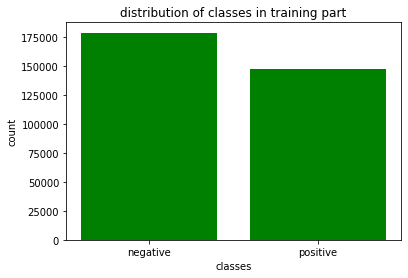

In [88]:
counts = Counter(train_labels)
plt.bar([0, 1], [counts[0.0], counts[1.0]],color='green')
plt.xticks([0, 1], ['negative', 'positive'])
plt.xlabel("classes")
plt.ylabel("count")
plt.title("distribution of classes in training part")
plt.show()

In [89]:
class_weights = compute_class_weight('balanced', np.unique(train_labels), train_labels)
print(class_weights)

[0.91264653 1.1058454 ]


# Model

In [149]:
class LSTMRecom(nn.Module):

    def __init__(self, embedding_weight_titles, embedding_weight_abs, hidden_dim, lstm_layers):
        super(LSTMRecom, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm_layers = lstm_layers
        
        self.embeddings_title = self._create_embedding(embedding_weight_titles)
        self.embeddings_abstract = self._create_embedding(embedding_weight_abs)

        self.lstm_title = nn.LSTM(self.embedding_dim, hidden_dim, lstm_layers, batch_first=True)
        self.lstm_abstract = nn.LSTM(self.embedding_dim, hidden_dim, lstm_layers, batch_first=True)
        self.fc_merge_1 = nn.Linear(hidden_dim * 2, hidden_dim)

        self.fc_imp_title = nn.Linear(self.embedding_dim, hidden_dim)
        self.fc_imp_abs = nn.Linear(self.embedding_dim, hidden_dim)
        self.fc_merge_2 = nn.Linear(hidden_dim * 2, hidden_dim)
        
        self.fc_clf = nn.Linear(hidden_dim * 2, 2)
        self.softmax = nn.Softmax(dim=1)

    def _create_embedding(self, embedding_weight, trainable=False):
        num_embeddings, embedding_dim = embedding_weight.shape
        self.embedding_dim = embedding_dim
        emb_layer = nn.Embedding(num_embeddings, embedding_dim)
        emb_layer.weights = torch.nn.Parameter(embedding_weight)
        if trainable:
            emb_layer.weight.requires_grad = True   
        else:
            emb_layer.weight.requires_grad = False
        return emb_layer   


    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden_title = (weight.new(self.lstm_layers, batch_size, self.hidden_dim).zero_().to('cuda'),
                      weight.new(self.lstm_layers, batch_size, self.hidden_dim).zero_().to('cuda'))

        weight = next(self.parameters()).data
        hidden_abstract = (weight.new(1, batch_size, self.hidden_dim).zero_().to('cuda'),
                      weight.new(1, batch_size, self.hidden_dim).zero_().to('cuda'))

        return hidden_title, hidden_title

    def forward(self, histories, impression, lengths, hidden_states_title=None, hidden_states_abs=None):
        sequence_len = histories.size()[1]
        titles_embed = self.embeddings_title(histories) #(batch, seq_len, embed_size)
        titles_embed = torch.nn.utils.rnn.pack_padded_sequence(titles_embed, lengths.cpu(), batch_first=True)
        lstm_out_title, _ = self.lstm_title(titles_embed, hidden_states_title) #(batch, seq_len, hidden_size)
        lstm_out_title, _ = torch.nn.utils.rnn.pad_packed_sequence(lstm_out_title, batch_first=True)
        lstm_out_title = lstm_out_title.sum(dim=1).div(sequence_len) #(batch , hidden_size)

        abstracts_embed = self.embeddings_abstract(histories) #(batch, seq_len, embed_size)
        abstracts_embed = torch.nn.utils.rnn.pack_padded_sequence(abstracts_embed, lengths.cpu(), batch_first=True)
        lstm_out_abs, _ = self.lstm_abstract(abstracts_embed, hidden_states_abs) #(batch, seq_len, hidden_size)
        lstm_out_abs, _ = torch.nn.utils.rnn.pad_packed_sequence(lstm_out_abs, batch_first=True)
        lstm_out_abs = lstm_out_abs.sum(dim=1).div(sequence_len)  #(batch , hidden_size)

        combined_title_abs = torch.cat([lstm_out_title, lstm_out_abs], dim=1) #(batch , 2*hidden_size)

        out_merge_1 = self.fc_merge_1(combined_title_abs) #(batch , 128)


        title_embed = self.embeddings_title(impression) # (batch, embed_size)
        abstract_embed = self.embeddings_abstract(impression) # (batch, embed_size)

        out_title = self.fc_imp_title(title_embed) # (batch, 128)
        out_abs = self.fc_imp_abs(abstract_embed)  # (batch, 128)

        combined_t_a = torch.cat([out_title, out_abs], dim=1) # (batch, 256)
        out_merge_2 = self.fc_merge_2(combined_t_a) # (batch, 128)

        combined = torch.cat([out_merge_1, out_merge_2], dim=1) 
        out = self.fc_clf(combined)
        out = self.softmax(out)
        return out

# Training

In [150]:
def binary_accuracy(preds, y):
    preds = preds.argmax(dim=1)
    correct = (preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc

In [151]:
BATCH_SIZE = 64
HIDDEN_DIM = 32
LSTM_LAYERS = 5
model = LSTMRecom(titles_weights, abstracts_weights, HIDDEN_DIM, LSTM_LAYERS)
weight=torch.tensor(class_weights, dtype=torch.float32).to('cuda')
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [152]:
model.to('cuda')

LSTMRecom(
  (embeddings_title): Embedding(61820, 768)
  (embeddings_abstract): Embedding(61820, 768)
  (lstm_title): LSTM(768, 32, num_layers=5, batch_first=True)
  (lstm_abstract): LSTM(768, 32, num_layers=5, batch_first=True)
  (fc_merge_1): Linear(in_features=64, out_features=32, bias=True)
  (fc_imp_title): Linear(in_features=768, out_features=32, bias=True)
  (fc_imp_abs): Linear(in_features=768, out_features=32, bias=True)
  (fc_merge_2): Linear(in_features=64, out_features=32, bias=True)
  (fc_clf): Linear(in_features=64, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)

In [153]:
best_val_acc = 0
epochs = 3
for epoch in range(epochs):
    hidden_states_title, hidden_states_abs = model.init_hidden(BATCH_SIZE)
    # hidden_states_title, hidden_states_abs = None, None
    time_diff = 0
    epoch_loss = 0
    epoch_acc = 0
    val_acc = 0
    val_loss = 0
    total_batches = int(len(train_histories)/BATCH_SIZE)
    for i_batch, i in enumerate(range(0, len(train_histories), BATCH_SIZE)):
        t1 = time()
        hists = train_histories[i:i+BATCH_SIZE]
        if len(hists) < BATCH_SIZE:
            continue
        hists = [torch.tensor(h) for h in hists]
        lenghts = [len(h) for h in hists]
        lenghts = torch.tensor(lenghts, dtype=torch.int32)
        hists = pad_sequence(hists, batch_first=True)
        hists = hists.to('cuda')
        imps = train_impressions[i:i+BATCH_SIZE]
        imps = torch.tensor(imps)
        imps = imps.to('cuda')
        labels = train_labels[i:i+BATCH_SIZE]
        labels = torch.tensor(labels)
        labels = labels.to('cuda')
        model.zero_grad()
        preds = model(hists, imps, lenghts, hidden_states_title, hidden_states_abs)
        loss = loss_function(preds, labels)
        acc = binary_accuracy(preds, labels)
        epoch_loss += loss
        epoch_acc += acc
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        time_diff = time()-t1
        remaining_time = time_diff*total_batches-time_diff*(i_batch)
        print('\r>> epoch {}, batch {}/{}, remaining time {:.5f}s, loss {:.5f}, acc {:.5f}, val loss {:.5f}, val acc {:.5f}'
        .format(epoch, i_batch, total_batches, remaining_time, loss, acc, val_loss, val_acc), end='')

        if i_batch % 100 == 0:
            val_loss = 0
            with torch.no_grad():
                loss = 0
                steps = int(len(val_histories)/BATCH_SIZE)
                for j in range(0, len(val_histories), BATCH_SIZE):
                    hists = val_histories[j:j+BATCH_SIZE]
                    hists = [torch.tensor(h) for h in hists]
                    lenghts = [len(h) for h in hists]
                    lenghts = torch.tensor(lenghts, dtype=torch.int32)
                    hists = pad_sequence(hists, batch_first=True)
                    hists = hists.to('cuda')
                    imps = val_impressions[j:j+BATCH_SIZE]
                    imps = torch.tensor(imps)
                    imps = imps.to('cuda')
                    labels = val_labels[j:j+BATCH_SIZE]
                    labels = torch.tensor(labels)
                    labels = labels.to('cuda')
                    tag_scores = model(hists, imps, lenghts)
                    val_loss += loss_function(tag_scores, labels)
                    val_acc += binary_accuracy(tag_scores, labels)
            val_loss /= steps
            val_acc /= steps
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model, 'model')

    print()
    print('>> epoch {} avg loss {:.5f}, avg acc {:.5f},val loss {:.5f}, val acc {:.5f}'
        .format(epoch, epoch_loss/total_batches, epoch_acc/total_batches, val_loss, val_acc))

>> epoch 0, batch 5098/5099, remaining time 0.01416s, loss 0.59198, acc 0.71875, val loss 0.71129, val acc 0.55744
>> epoch 0 avg loss 0.63933, avg acc 0.63909,val loss 0.71129, val acc 0.55744
>> epoch 1, batch 5098/5099, remaining time 0.01421s, loss 0.59319, acc 0.71875, val loss 0.71788, val acc 0.55122
>> epoch 1 avg loss 0.63203, avg acc 0.65046,val loss 0.71788, val acc 0.55122
>> epoch 2, batch 5098/5099, remaining time 0.01416s, loss 0.59356, acc 0.71875, val loss 0.72265, val acc 0.54829
>> epoch 2 avg loss 0.62997, avg acc 0.65335,val loss 0.72265, val acc 0.54829


#Testing

In [164]:
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, roc_auc_score

model = torch.load('model')
positive_class_probs = []
all_preds = []
test_loss = 0
test_acc = 0
steps = int(len(test_histories)/BATCH_SIZE)
with torch.no_grad():
    for j in range(0, len(test_histories), BATCH_SIZE):
        hists = test_histories[j:j+BATCH_SIZE]
        hists = [torch.tensor(h) for h in hists]
        lenghts = [len(h) for h in hists]
        lenghts = torch.tensor(lenghts, dtype=torch.int32)
        hists = pad_sequence(hists, batch_first=True)
        hists = hists.to('cuda')
        imps = test_impressions[j:j+BATCH_SIZE]
        imps = torch.tensor(imps)
        imps = imps.to('cuda')
        labels = test_labels[j:j+BATCH_SIZE]
        labels = torch.tensor(labels)
        labels = labels.to('cuda')
        preds = model(hists, imps, lenghts)
        all_preds.extend(preds.cpu().numpy())
        positive_class_probs.extend([p for p in preds[:, -1].cpu().numpy()])
        test_loss += loss_function(preds, labels)
        test_acc += binary_accuracy(preds, labels)
test_loss /= steps
test_acc /= steps

auc = roc_auc_score(test_labels, positive_class_probs)
fpr, tpr, _ = roc_curve(test_labels,  positive_class_probs)
preds = np.argmax(np.array(all_preds).reshape(-1, 2), axis=1)
f1 = f1_score(test_labels, preds)

print('test loss {} test acc {} test auc {} f1-score {}'.format(test_loss, test_acc, auc, f1))
print('confusion matrix:')
print(confusion_matrix(test_labels, preds))

test loss 0.7000288367271423 test acc 0.5717147588729858 test auc 0.5820756497583252 f1-score0.3029721955896453
confusion matrix:
[[2345  452]
 [1729  474]]


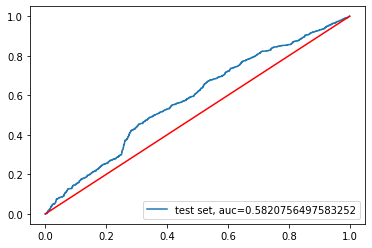

In [155]:
plt.plot(fpr,tpr,label="test set, auc="+str(auc))
plt.plot([0, 1], [0, 1], color='red')
plt.legend(loc=4)
plt.show()